# Project 1

As discussed in class, two groups of asteroid accompanying the planet Jupiter in its orbit around the Sun—the Trojan asteroids. The two groups sit at points of stable equilibrium (the Lagrange points) preceding and trailing Jupiter at an angular distance of π/3 radians. The combination of the gravitational attraction of the Sun and Jupiter gives a resultant force on a Trojan asteroid towards the center of mass of the two bodies such that the centripetal acceleration causes the asteroid to orbit with the same period as the planet.

Note that units suitable for this system are normalized for the Solar System: the mass of the Sun (M⊙) is taken as unit mass, unit distance is the astronomical unit (AU), and unit time is one year. For such a system, the gravitational constant G is 4π2. The mass of Jupiter can be taken to be 0.001 M⊙ and the average distance of Jupiter from the Sun is 5.2 AU. The asteroids' masses are negligible in this system.

In [1]:
import matplotlib    # Library used for plotting
import numpy as np   # Numerical library
import matplotlib.pyplot as plt # Plot commands

import scipy         # Another numerical library
from scipy import integrate

# Define some colors using the RGB format

CF_red = (204/255, 121/255, 167/255)
CF_vermillion = (213/255, 94/255, 0)
CF_orange = (230/255, 159/255, 0)
CF_yellow = (240/255, 228/255, 66/255)
CF_green = (0, 158/255, 115/255)
CF_sky = (86/255, 180/255, 233/255)
CF_blue = (0, 114/255, 178/255)
CF_black = (0, 0, 0)

## Part 1 - Setup

Write a program to solve the equations of motion for this system numerically, and demonstrate that the asteroids will stay at the Lagrange points over many orbits of Jupiter around the Sun. This should show that your program is operating correctly with no numerical instabilities being propagated during the computation.

In [9]:
# Parameters
days_J = 4331   # Days per Jupiter year
M_S = 1         # Mass of the Sun
M_J = 0.001     # Mass of Jupiter
radius_J = 5.2  # Radius of Jupiter's orbit

t_min = 0
t_max = 100 * days_J
epsilon = 10

velocity_J = 2 * np.pi * radius_J / days_J # Average velocity of Jupiter per day
radius_S = radius_J * M_J / (M_S + M_J) # Radius of the Sun's orbit
velocity_S = 2 * np.pi * radius_S / days_J # Average velocity of the Sun per day

position_x_L4 = radius_J * np.cos(np.pi / 3)
position_y_L4 = radius_J * np.sin(np.pi / 3)
position_x_L5 = radius_J * np.cos(np.pi / 3)
position_y_L5 = -radius_J * np.sin(np.pi / 3)

velocity_x_L4 = velocity_J * -0.866
velocity_y_L4 = velocity_J * 0.5
velocity_x_L5 = velocity_J * 0.866
velocity_y_L5 = velocity_J * 0.5

init = np.array([-radius_S, 0, 0, -velocity_S, # Sun
                radius_J, 0, 0, velocity_J, # Jupiter
                position_x_L4, position_y_L4, velocity_x_L4, velocity_y_L4, # Asteroid L4
                position_x_L5, position_y_L5, velocity_x_L5, velocity_y_L5]) # Asteroid L4

Here we define the parameters used in the model of the three-body problem. I define the  number of Earth days in a Jupiter year, the masses of the Sun and Jupiter, and the radius of Jupiter's orbit.  I also define the time ranges and the maximum step size for the numerical solution of the equations of motion. Using these parameters, I calculate some important parameters for the system, such as the velocity of Jupiter's orbit, the radius of the Sun's orbit and the velocity of the Sun's orbit. 

Now, I can calculate the positions and velocities of the asteroids in the Lagrange points using some trigonometry. Then, I create an initial state containing the initial positions and velocities of the Sun, Jupiter, an asteroid in the L4 point, an asteroid in the L5 point. 

In [10]:
# Functions
d = -2.96 * 10 ** (-4) # G * M / AU^3 * 86400^2

def general_derivative(t, state, mass_J):
    x_S, y_S, v_x_S, v_y_S, \
        x_J, y_J, v_x_J, v_y_J, \
        x_A4, y_A4, v_x_A4, v_y_A4, \
        x_A5, y_A5, v_x_A5, v_y_A5 = state

    # Distances
    r_JS = np.sqrt((x_J - x_S) ** 2 + (y_J - y_S) ** 2)  # Distance from Jupiter to Sun
    
    r_A4S = np.sqrt((x_A4 - x_S) ** 2 + (y_A4 - y_S) ** 2)  # Distance from L4 Asteroid to Sun
    r_A4J = np.sqrt((x_A4 - x_J) ** 2 + (y_A4 - y_J) ** 2)  # Distance from L4 Asteroid to Jupiter
    
    r_A5S = np.sqrt((x_A5 - x_S) ** 2 + (y_A5 - y_S) ** 2)  # Distance from L5 Asteroid to Sun
    r_A5J = np.sqrt((x_A5 - x_J) ** 2 + (y_A5 - y_J) ** 2)  # Distance from L5 Asteroid to Jupiter

    # Accelerations
    a_x_SJ =  d * mass_J * (x_S - x_J) / (r_JS ** 3) # Sun's acceleration due to Jupiter
    a_y_SJ =  d * mass_J * (y_S - y_J) / (r_JS ** 3)

    a_x_JS = d * M_S * (x_J - x_S) / (r_JS ** 3)  # Jupiter's acceleration due to the Sun
    a_y_JS = d * M_S * (y_J - y_S) / (r_JS ** 3)

    a_x_A4S = d * M_S * (x_A4 - x_S) / (r_A4S ** 3)  # L4 Asteroid's acceleration due to the Sun
    a_y_A4S = d * M_S * (y_A4 - y_S) / (r_A4S ** 3)
    a_x_A4J = d * mass_J * (x_A4 - x_J) / (r_A4J ** 3)  # L4 Asteroid's acceleration due to Jupiter
    a_y_A4J = d * mass_J * (y_A4 - y_J) / (r_A4J ** 3)
    a_x_A4 = a_x_A4S + a_x_A4J  # Total x acceleration of the L4 Asteroid
    a_y_A4 = a_y_A4S + a_y_A4J  # Total y acceleration of the L4 Asteroid

    a_x_A5S = d * M_S * (x_A5 - x_S) / (r_A5S ** 3)  # L5 Asteroid's acceleration due to the Sun
    a_y_A5S = d * M_S * (y_A5 - y_S) / (r_A5S ** 3)
    a_x_A5J = d * mass_J * (x_A5 - x_J) / (r_A5J ** 3)  # L5 Asteroid's acceleration due to Jupiter
    a_y_A5J = d * mass_J * (y_A5 - y_J) / (r_A5J ** 3)
    a_x_A5 = a_x_A5S + a_x_A5J  # Total x acceleration of the L5 Asteroid
    a_y_A5 = a_y_A5S + a_y_A5J  # Total y acceleration of the L5 Asteroid

    return np.array([v_x_S, v_y_S, a_x_SJ, a_y_SJ, \
                        v_x_J, v_y_J, a_x_JS, a_y_JS, \
                        v_x_A4, v_y_A4, a_x_A4, a_y_A4, \
                        v_x_A5, v_y_A5, a_x_A5, a_y_A5])

Before writing the general derivative function, I first define the constant 'd' calculated the same way as we did in class using $G \times M / AU^3 \times 86400^2$. Then, I define the general derivative function that takes in the current state of the system and the mass of Jupiter and returns the next state. 

This is done by first desconstructing the state that is passed in and calculating the accelerations due to the different bodies. To calculate the accelerations, I calculate the distances between the bodies and then calculate the accelerations as we did in class. We need to account for Sun's acceleration due to Jupiter, Jupiter's acceleration due to the Sun, and the asteroids' acceleration due to the Sun and Jupiter. 

Finally, I return the derivative of the state, where the next positions are the previous velocities and the next velocities are the accelerations.

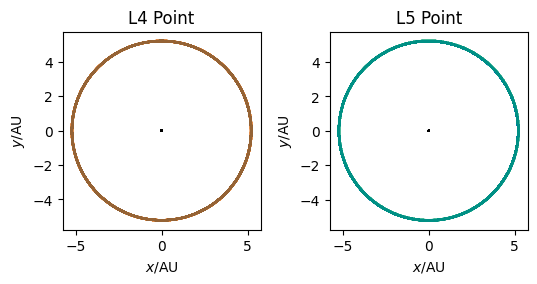

In [13]:
# Solution
def derivative(t, state):
    return general_derivative(t, state, M_J)

solution = integrate.solve_ivp(derivative, [t_min, t_max], init, max_step = epsilon)

x_S = solution.y[0]
y_S = solution.y[1]

x_J = solution.y[4]
y_J = solution.y[5]

x_A4 = solution.y[8]
y_A4 = solution.y[9]

x_A5 = solution.y[12]
y_A5 = solution.y[13]

# Plotting
fig, (ax_L4, ax_L5) = plt.subplots(1, 2)
fig.set_size_inches(6, 3)

ax_L4.plot(x_S, y_S, color = CF_black)
ax_L4.plot(x_J, y_J, color = CF_blue)
ax_L4.plot(x_A4, y_A4, color = CF_vermillion, alpha = 0.7)
ax_L4.set(title = "L4 Point", xlabel = "$x$/AU", ylabel = "$y$/AU")
ax_L4.set_aspect("equal")

ax_L5.plot(x_S, y_S, color = CF_black)
ax_L5.plot(x_J, y_J, color = CF_blue)
ax_L5.plot(x_A5, y_A5, color = CF_green, alpha = 0.7)
ax_L5.set(title = "L5 Point", xlabel = "$x$/AU", ylabel = "$y$/AU")
ax_L5.set_aspect("equal")

plt.subplots_adjust(wspace = 0.35)

To check that everything is working as expected, I produced a plot. I define the specific derivative with the correct value for the mass of Jupiter. Then using the `solve_ivp` function, I solve the equations of motion for the system using the initial state and the derivative function for the time range and maximum step. I then plot the positions of the Sun, Jupiter, and the asteroids over 100 years. The plot looks as expected and the asteroids are staying at the Lagrange points over many orbits of Jupiter around the Sun.

## Part 2 - Position Stability

Vary the initial positions of the asteroids and plot their positions through a few hundred orbits. Your results should show that they oscillate about the Lagrange points, but do not escape from the stable position. Considering both the leading and trailing groups, determine a way to quantitatively describe how far the stable orbits wander from the Lagrange points. Plot their wander as a function of their initial position perturbation.

In [14]:
def wander(solution):
    X_L4 = solution.y[8]
    Y_L4 = solution.y[9]

    X_L5 = solution.y[12]
    Y_L5 = solution.y[13]

    wander_distance_L4 = np.sqrt(X_L4 ** 2 + Y_L4 ** 2) - 5.2
    wander_distance_L5 = np.sqrt(X_L5 ** 2 + Y_L5 ** 2) - 5.2

    return wander_distance_L4, wander_distance_L5

I define a helpful `wander` function that takes in the solution and finds the distance of the asteroids from the origin (subtracting 5.2 to account for the radius of Jupiter's orbit). This function is then used to calculate the wander of the asteroids due to various different initial conditions.

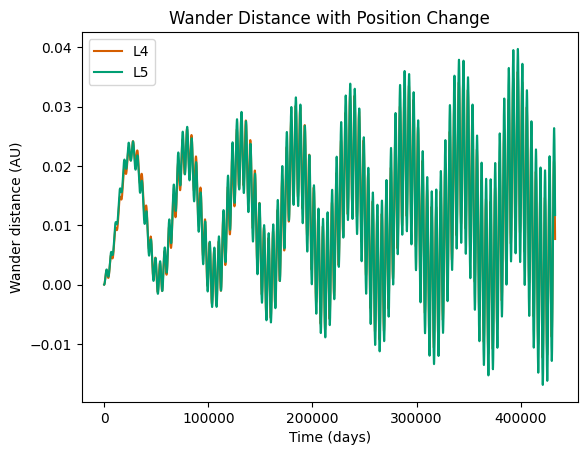

In [31]:
radius_delta = 0    # Delta for the radius of Jupiter's orbit
angle_delta = 0     # Delta for the angle of the L4 and L5 points

position_x_L4 = (radius_J + radius_delta) * np.cos((np.pi / 3) + angle_delta)
position_y_L4 = (radius_J + radius_delta) * np.sin((np.pi / 3) + angle_delta)
position_x_L5 = (radius_J + radius_delta) * np.cos((np.pi / 3) + angle_delta)
position_y_L5 = -(radius_J + radius_delta) * np.sin((np.pi / 3 + angle_delta))

init_p2 = np.array([-radius_S, 0, 0, -velocity_S, # Sun
                radius_J, 0, 0, velocity_J, # Jupiter
                position_x_L4, position_y_L4, velocity_x_L4, velocity_y_L4, # Asteroid L4
                position_x_L5, position_y_L5, velocity_x_L5, velocity_y_L5]) # Asteroid L4

solution_p2 = integrate.solve_ivp(derivative, [t_min, t_max], init_p2, max_step = epsilon)

ts = solution_p2.t
wander_distance_L4, wander_distance_L5 = wander(solution_p2)

fig, ax = plt.subplots(1, 1)
ax.plot(ts, wander_distance_L4, color = CF_vermillion, label = "L4")
ax.plot(ts, wander_distance_L5, color = CF_green, label = "L5")
ax.set(title = "Wander Distance with Position Change", xlabel = "Time (days)", ylabel = "Wander distance (AU)")
ax.legend()

Here, I tried to make the code more dynamic by introducing the `radius_delta` and the `angle_delta`. The radius delta changes the radius of Jupiter's orbit which is used to calculated the positions of the L4 and L5 points. The angle delta changes the angle of the L4 and L5 points which also affects the position of the L4 and L5 points. 

The next part is the same as before and I calculate the varied positions of the asteroids and update the initial state to run the simulation. I then plot the wander of the asteroids as a function of the time. When there are no deltas and initial state is the unvaried one, the plot shows that the wander of the asteroids increases slowly as the time increases. Although the values are still within 0.04 AU for 100 orbits, this shows that the simulation is not perfectly accurate and might have some numerical instabilities. 

When I introduce the radius delta and the angle delta, the wander of the asteroids increases significantly. This is expected as the initial positions of the asteroids are varied and the wander of the asteroids is expected to increase.

In [16]:
# Changing the radius of Jupiter's orbit
radius_delta = np.linspace(-1, 1, 50)
angle_delta = 0

max_wander_L4 = np.zeros_like(radius_delta)
max_wander_L5 = np.zeros_like(radius_delta)

mean_wander_L4 = np.zeros_like(radius_delta)
mean_wander_L5 = np.zeros_like(radius_delta)

std_wander_L4 = np.zeros_like(radius_delta)
std_wander_L5 = np.zeros_like(radius_delta)

for i, rd in enumerate(radius_delta):
    position_x_L4_p2 = (radius_J + rd) * np.cos((np.pi / 3) + angle_delta)
    position_y_L4_p2 = (radius_J + rd) * np.sin((np.pi / 3) + angle_delta)
    position_x_L5_p2 = (radius_J + rd) * np.cos((np.pi / 3) + angle_delta)
    position_y_L5_p2 = -(radius_J + rd) * np.sin((np.pi / 3 + angle_delta))

    init_p2 = np.array([-radius_S, 0, 0, -velocity_S, # Sun
                    radius_J, 0, 0, velocity_J, # Jupiter
                    position_x_L4_p2, position_y_L4_p2, velocity_x_L4, velocity_y_L4, # Asteroid L4
                    position_x_L5_p2, position_y_L5_p2, velocity_x_L5, velocity_y_L5]) # Asteroid L4

    solution_p2 = integrate.solve_ivp(derivative, [t_min, t_max], init_p2, max_step = epsilon)
    wander_distance_L4, wander_distance_L5 = wander(solution_p2)

    max_wander_L4[i] = np.max(wander_distance_L4)
    max_wander_L5[i] = np.max(wander_distance_L5)
    mean_wander_L4[i] = np.mean(wander_distance_L4)
    mean_wander_L5[i] = np.mean(wander_distance_L5)
    std_wander_L4[i] = np.std(wander_distance_L4)
    std_wander_L5[i] = np.std(wander_distance_L5)

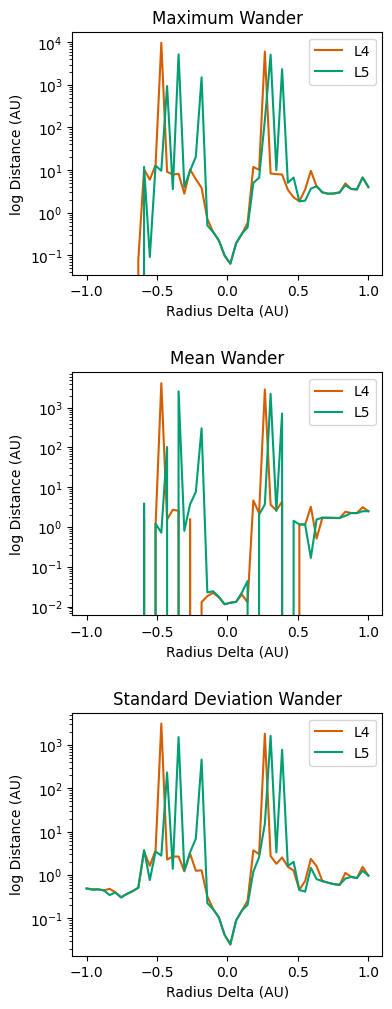

In [17]:
fig, (ax_max, ax_mean, ax_std) = plt.subplots(3, 1)
fig.set_size_inches(4, 12)

ax_max.plot(radius_delta, max_wander_L4, color = CF_vermillion, label = "L4")
ax_max.plot(radius_delta, max_wander_L5, color = CF_green, label = "L5")
ax_max.set(title = "Maximum Wander", xlabel = "Radius Delta (AU)", ylabel = "log Distance (AU)")
ax_max.set_yscale("log")
ax_max.legend()

ax_mean.plot(radius_delta, mean_wander_L4, color = CF_vermillion, label = "L4")
ax_mean.plot(radius_delta, mean_wander_L5, color = CF_green, label = "L5")
ax_mean.set(title = "Mean Wander", xlabel = "Radius Delta (AU)", ylabel = "log Distance (AU)")
ax_mean.set_yscale("log")
ax_mean.legend()

ax_std.plot(radius_delta, std_wander_L4, color = CF_vermillion, label = "L4")
ax_std.plot(radius_delta, std_wander_L5, color = CF_green, label = "L5")
ax_std.set(title = "Standard Deviation Wander", xlabel = "Radius Delta (AU)", ylabel = "log Distance (AU)")
ax_std.set_yscale("log")
ax_std.legend()

plt.subplots_adjust(hspace = 0.4)

In [18]:
# Changing the initial angle of the asteroid
radius_delta = 0
angle_delta = np.linspace(-np.pi, np.pi, 50)

max_wander_l4 = np.zeros_like(angle_delta)
max_wander_l5 = np.zeros_like(angle_delta)

mean_wander_l4 = np.zeros_like(angle_delta)
mean_wander_l5 = np.zeros_like(angle_delta)

std_wander_l4 = np.zeros_like(angle_delta)
std_wander_l5 = np.zeros_like(angle_delta)

for i, ad in enumerate(angle_delta):
    position_x_L4_p2 = (radius_J + radius_delta) * np.cos((np.pi / 3) + ad)
    position_y_L4_p2 = (radius_J + radius_delta) * np.sin((np.pi / 3) + ad)
    position_x_L5_p2 = (radius_J + radius_delta) * np.cos((np.pi / 3) + ad)
    position_y_L5_p2 = -(radius_J + radius_delta) * np.sin((np.pi / 3 + ad))

    init_p2 = np.array([-radius_S, 0, 0, -velocity_S, # Sun
                    radius_J, 0, 0, velocity_J, # Jupiter
                    position_x_L4_p2, position_y_L4_p2, velocity_x_L4, velocity_y_L4, # Asteroid L4
                    position_x_L5_p2, position_y_L5_p2, velocity_x_L5, velocity_y_L5]) # Asteroid L4

    solution_p2 = integrate.solve_ivp(derivative, [t_min, t_max], init_p2, max_step = epsilon)
    wander_distance_L4, wander_distance_L5 = wander(solution_p2)
    
    max_wander_L4[i] = np.max(wander_distance_L4)
    max_wander_L5[i] = np.max(wander_distance_L5)
    mean_wander_L4[i] = np.mean(wander_distance_L4)
    mean_wander_L5[i] = np.mean(wander_distance_L5)
    std_wander_L4[i] = np.std(wander_distance_L4)
    std_wander_L5[i] = np.std(wander_distance_L5)

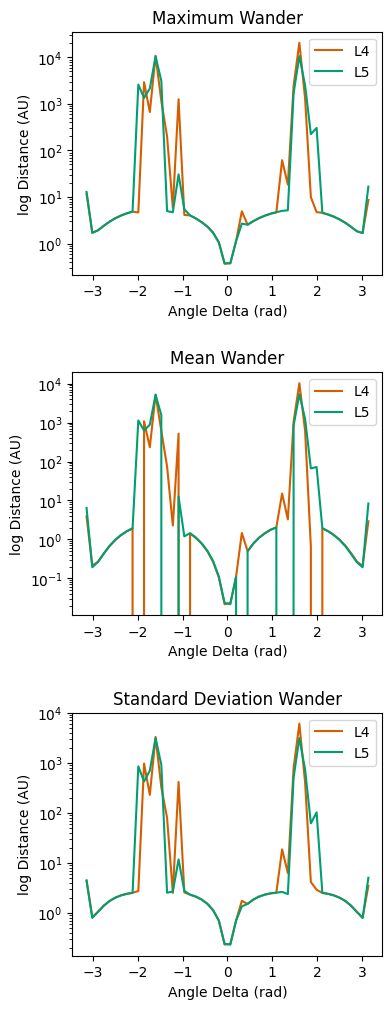

In [19]:
fig, (ax_max, ax_mean, ax_std) = plt.subplots(3, 1)
fig.set_size_inches(4, 12)

ax_max.plot(angle_delta, max_wander_L4, color = CF_vermillion, label = "L4")
ax_max.plot(angle_delta, max_wander_L5, color = CF_green, label = "L5")
ax_max.set(title = "Maximum Wander", xlabel = "Angle Delta (rad)", ylabel = "log Distance (AU)")
ax_max.set_yscale("log")
ax_max.legend()

ax_mean.plot(angle_delta, mean_wander_L4, color = CF_vermillion, label = "L4")
ax_mean.plot(angle_delta, mean_wander_L5, color = CF_green, label = "L5")
ax_mean.set(title = "Mean Wander", xlabel = "Angle Delta (rad)", ylabel = "log Distance (AU)")
ax_mean.set_yscale("log")
ax_mean.legend()

ax_std.plot(angle_delta, std_wander_L4, color = CF_vermillion, label = "L4")
ax_std.plot(angle_delta, std_wander_L5, color = CF_green, label = "L5")
ax_std.set(title = "Standard Deviation Wander", xlabel = "Angle Delta (rad)", ylabel = "log Distance (AU)")
ax_std.set_yscale("log")
ax_std.legend()

plt.subplots_adjust(hspace = 0.4)

## Part 3 - Velocity Stability

Give your particles some initial velocity relative to the Lagrange points. Determine the range of initial velocity vectors for which the orbits remain captured by the Lagrange points. 

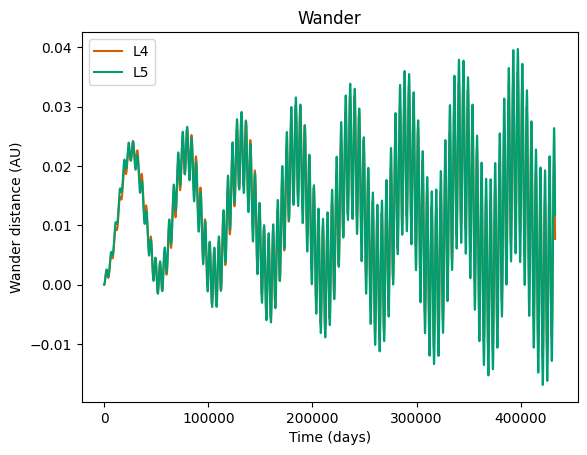

In [20]:
velocity_delta = 0

init_p3 = np.array([-radius_S, 0, 0, -velocity_S, # Sun
                radius_J, 0, 0, velocity_J, # Jupiter
                position_x_L4, position_y_L4, velocity_x_L4 - velocity_delta, velocity_y_L4 + velocity_delta, # Asteroid L4
                position_x_L5, position_y_L5, velocity_x_L5 + velocity_delta, velocity_y_L5 + velocity_delta]) # Asteroid L4

solution_p3 = integrate.solve_ivp(derivative, [t_min, t_max], init_p3, max_step = epsilon)

ts = solution_p3.t
wander_distance_L4, wander_distance_L5 = wander(solution_p3)

fig, ax = plt.subplots(1, 1)
ax.plot(ts, wander_distance_L4, color = CF_vermillion, label = "L4")
ax.plot(ts, wander_distance_L5, color = CF_green, label = "L5")
ax.set(title = "Wander", xlabel = "Time (days)", ylabel = "Wander distance (AU)")
ax.legend()

In [21]:
velocity_delta = np.linspace(-0.02, 0.02, 50)

max_wander_l4 = np.zeros_like(velocity_delta)
max_wander_l5 = np.zeros_like(velocity_delta)

mean_wander_l4 = np.zeros_like(velocity_delta)
mean_wander_l5 = np.zeros_like(velocity_delta)

std_wander_l4 = np.zeros_like(velocity_delta)
std_wander_l5 = np.zeros_like(velocity_delta)

for i, vd in enumerate(velocity_delta):
    init_p3 = np.array([-radius_S, 0, 0, -velocity_S, # Sun
                    radius_J, 0, 0, velocity_J, # Jupiter
                    position_x_L4, position_y_L4, velocity_x_L4 - vd, velocity_y_L4 + vd, # Asteroid L4
                    position_x_L5, position_y_L5, velocity_x_L5 + vd, velocity_y_L5 + vd]) # Asteroid L4

    solution_p3 = integrate.solve_ivp(derivative, [t_min, t_max], init_p3, max_step = epsilon)
    wander_distance_L4, wander_distance_L5 = wander(solution_p3)

    max_wander_L4[i] = np.max(wander_distance_L4)
    max_wander_L5[i] = np.max(wander_distance_L5)
    mean_wander_L4[i] = np.mean(wander_distance_L4)
    mean_wander_L5[i] = np.mean(wander_distance_L5)
    std_wander_L4[i] = np.std(wander_distance_L4)
    std_wander_L5[i] = np.std(wander_distance_L5)

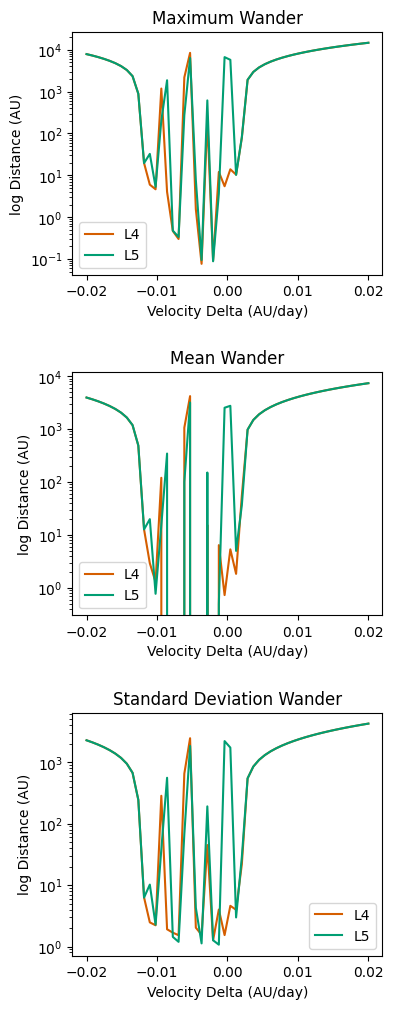

In [22]:
fig, (ax_max, ax_mean, ax_std) = plt.subplots(3, 1)
fig.set_size_inches(4, 12)

ax_max.plot(velocity_delta, max_wander_L4, color = CF_vermillion, label = "L4")
ax_max.plot(velocity_delta, max_wander_L5, color = CF_green, label = "L5")
ax_max.set(title = "Maximum Wander", xlabel = "Velocity Delta (AU/day)", ylabel = "log Distance (AU)")
ax_max.set_yscale("log")
ax_max.legend()

ax_mean.plot(velocity_delta, mean_wander_L4, color = CF_vermillion, label = "L4")
ax_mean.plot(velocity_delta, mean_wander_L5, color = CF_green, label = "L5")
ax_mean.set(title = "Mean Wander", xlabel = "Velocity Delta (AU/day)", ylabel = "log Distance (AU)")
ax_mean.set_yscale("log")
ax_mean.legend()

ax_std.plot(velocity_delta, std_wander_L4, color = CF_vermillion, label = "L4")
ax_std.plot(velocity_delta, std_wander_L5, color = CF_green, label = "L5")
ax_std.set(title = "Standard Deviation Wander", xlabel = "Velocity Delta (AU/day)", ylabel = "log Distance (AU)")
ax_std.set_yscale("log")
ax_std.legend()

plt.subplots_adjust(hspace = 0.4)

## Part 4 - Mass Dependence

Similar "Trojan" asteroids are also present in the orbit of Mars. Run your program for a range of planetary masses (within two orders of magnitude of Jupiter's mass should work). Explore the range of distances that the asteroids wander as a function of the planetary mass.

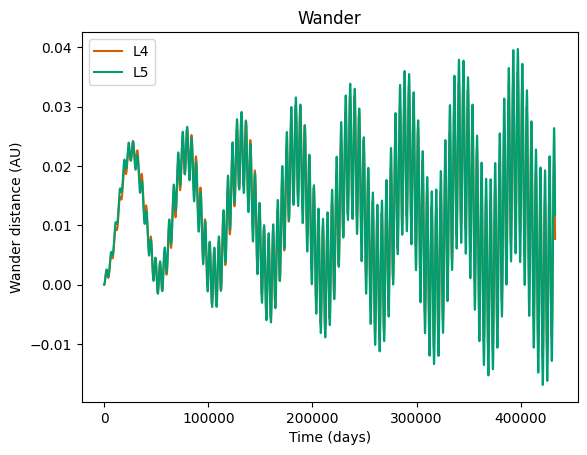

In [23]:
M_J = 0.001

derivative_p4 = lambda t, state: general_derivative(t, state, M_J)

solution_p4 = integrate.solve_ivp(derivative_p4, [t_min, t_max], init, max_step = epsilon)

ts = solution_p4.t
wander_distance_L4, wander_distance_L5 = wander(solution_p4)

fig, ax = plt.subplots(1, 1)
ax.plot(ts, wander_distance_L4, color = CF_vermillion, label = "L4")
ax.plot(ts, wander_distance_L5, color = CF_green, label = "L5")
ax.set(title = "Wander", xlabel = "Time (days)", ylabel = "Wander distance (AU)")
ax.legend()

In [28]:
# M_J_p4 = [1.e-05, 1.e-04, 1.e-02, 1.e-01]

def plot_for_mass(mass, ax):
    derivative_p4 = lambda t, state: general_derivative(t, state, mass)
    solution_p4 = integrate.solve_ivp(derivative_p4, [t_min, t_max], init, max_step = epsilon)
    wander_distance_L4, wander_distance_L5 = wander(solution_p4)

    ax.plot(solution_p4.t, wander_distance_L4, color = CF_vermillion, label = "L4")
    ax.plot(solution_p4.t, wander_distance_L5, color = CF_green, label = "L5")
    ax.set(title = f"Wander for Mass {mass}", xlabel = "Time (days)", ylabel = "Wander distance (AU)")
    ax.legend()

    print(f"""
Statistics for Mass {mass}

L4 Maximum Wander Distance: {np.max(wander_distance_L4)}
L4 Mean Wander Distance: {np.mean(wander_distance_L4)}
L4 Standard Deviation Wander Distance: {np.std(wander_distance_L4)}

L5 Maximum Wander Distance: {np.max(wander_distance_L5)}
L5 Mean Wander Distance: {np.mean(wander_distance_L5)}
L5 Standard Deviation Wander Distance: {np.std(wander_distance_L5)}
""")


Statistics for Mass 1e-05

L4 Maximum Wander Distance: 3.2313343922260076
L4 Mean Wander Distance: 0.18796212936882983
L4 Standard Deviation Wander Distance: 1.3003142235596663

L5 Maximum Wander Distance: 3.2256179884892076
L5 Mean Wander Distance: 0.1902183411788807
L5 Standard Deviation Wander Distance: 1.2941570813481236


Statistics for Mass 0.0001

L4 Maximum Wander Distance: 2.944876043393694
L4 Mean Wander Distance: 0.15705485462456695
L4 Standard Deviation Wander Distance: 1.1846414124933742

L5 Maximum Wander Distance: 2.942615026042584
L5 Mean Wander Distance: 0.1557658325978277
L5 Standard Deviation Wander Distance: 1.1808652971489106


Statistics for Mass 0.01

L4 Maximum Wander Distance: 28.97021780420963
L4 Mean Wander Distance: 10.340662358115262
L4 Standard Deviation Wander Distance: 8.323682321624027

L5 Maximum Wander Distance: 29.01132794162741
L5 Mean Wander Distance: 10.255380167366468
L5 Standard Deviation Wander Distance: 8.301426635331143


Statistics for Mass

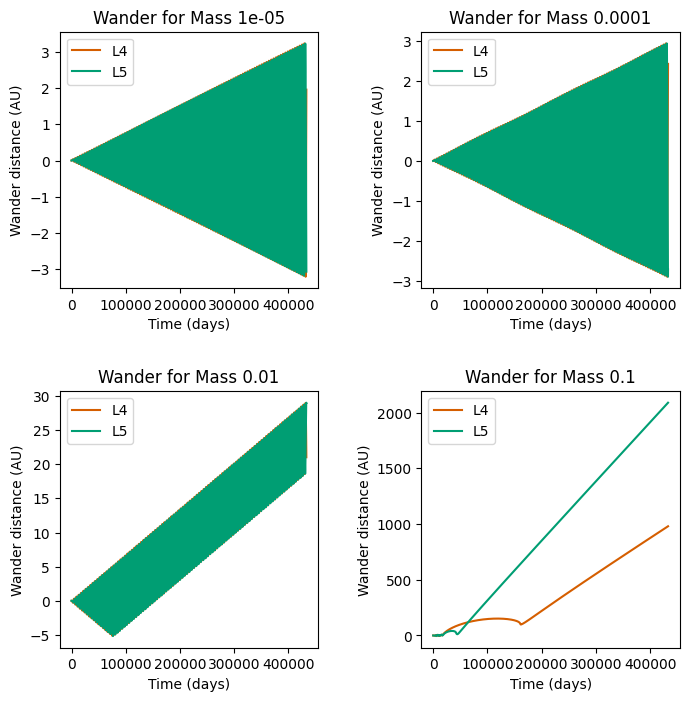

In [29]:
fig, ((ax_M1, ax_M2), (ax_M3, ax_M4)) = plt.subplots(2, 2)
fig.set_size_inches(8, 8)

plot_for_mass(1.e-05, ax_M1)
plot_for_mass(1.e-04, ax_M2)
plot_for_mass(1.e-02, ax_M3)
plot_for_mass(1.e-01, ax_M4)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)